## 2023 06/16 Palm Cropping Experimentation

*Last Updated*: 2023-09-25

### Authors
* Hannah Zhang (hannahzhang@ucsb.edu)


### Overview
This Jupyter notebook is intended to demonstrate

* generating rectangles from cropped palm images
* generating multiple cropped images per hand


### Key Results

- rectangles are not uniform in size or an automated process that transforms rectangles based on palm size
- can experiment with cropping more landmarks per hand for automl experiments

In [41]:
# --- Imports

# External packages
from pycaret import regression
from pycaret.datasets import get_data
import os
import cv2
from dermaml import data
from dermaml import features
import PIL
from PIL import Image
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import numpy as np

In [42]:
def load_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')):
                # Create the full path to the image file
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

image_folder = '/Users/hannahzhang/Downloads/test_ims/'
image_paths = load_image_paths(image_folder)

print(image_paths)

['/Users/hannahzhang/Downloads/test_ims/16B45EFF-7F1D-4437-B8FA-C7D4ADBF4F92.jpeg', '/Users/hannahzhang/Downloads/test_ims/7F301A45-1207-4B6A-A05A-72B320B25E95.jpeg', '/Users/hannahzhang/Downloads/test_ims/6C550AAE-8181-41AA-829C-B42D255A9E2F.jpeg', '/Users/hannahzhang/Downloads/test_ims/5A7E3A5F-334A-4C8D-9E0D-BD435389C81E.jpeg', '/Users/hannahzhang/Downloads/test_ims/image007.jpg', '/Users/hannahzhang/Downloads/test_ims/E4FE4EBA-68AA-434C-8260-54646D0C4AC3.jpeg']


In [43]:
image_folder = '/Users/hannahzhang/Downloads/test_ims/'
image_files = os.listdir(image_folder)

images = []
for filename in image_files:
    img = cv2.imread(os.path.join(image_folder, filename))
    if img is not None:
        images.append(img)
        print(filename)

16B45EFF-7F1D-4437-B8FA-C7D4ADBF4F92.jpeg
7F301A45-1207-4B6A-A05A-72B320B25E95.jpeg
6C550AAE-8181-41AA-829C-B42D255A9E2F.jpeg
5A7E3A5F-334A-4C8D-9E0D-BD435389C81E.jpeg
image007.jpg
E4FE4EBA-68AA-434C-8260-54646D0C4AC3.jpeg


In [57]:
removed_ims = []

for im in images:
    output = data.remove(im)
    removed_ims.append(output)

In [44]:
cropped_ims = []
failed_ims = []
cropped_filenames = []

for path in image_paths:
    output = data.crop_palm(path)
    if output is not None:
        cropped_ims.append(output)
        filename = os.path.basename(path)
        cropped_filenames.append(filename)
    else:
        failed_ims.append(path)

No hands detected in the image.


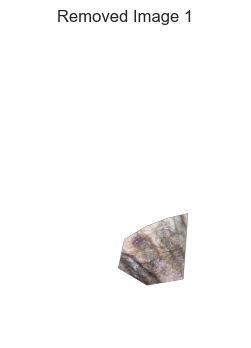

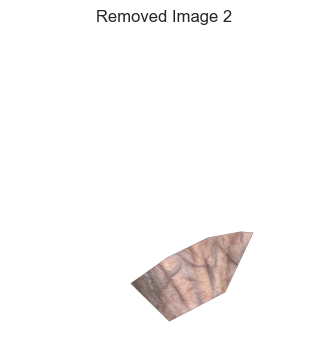

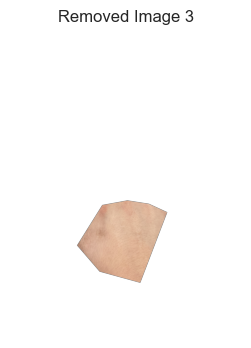

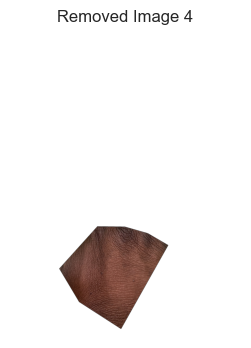

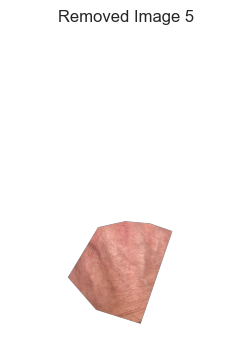

In [45]:
# Assuming removed_ims contains a list of BGRA images
for i, im in enumerate(cropped_ims):
    # Convert BGRA image to RBGA
    # grayscale_im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)

    plt.figure(figsize=(4, 4))
    plt.imshow(im, cmap='gray') 
    plt.title(f'Removed Image {i + 1}')
    plt.axis('off')
    plt.show()

In [46]:
print(failed_ims)

['/Users/hannahzhang/Downloads/test_ims/6C550AAE-8181-41AA-829C-B42D255A9E2F.jpeg']


In [47]:
cropped_rect_ims = []

for im in cropped_ims:
    # Load an image
    image = im

    # Create a grayscale version of the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (which corresponds to the largest rectangle)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the coordinates of the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate the new width and height (50% of the original size)
    new_w = w // 3
    new_h = h // 3

    # Calculate the new (x, y) coordinates to keep the rectangle centered
    new_x = x + (w - new_w) // 2
    new_y = y + (h - new_h) // 2


    cropped_image = image[new_y:new_y + new_h, new_x:new_x + new_w]

    cropped_rect_ims.append(cropped_image)




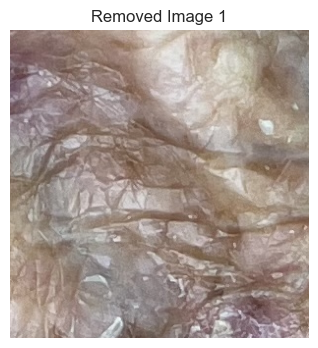

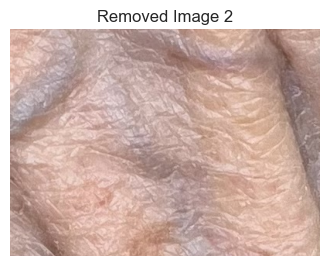

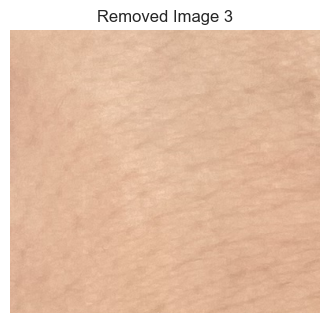

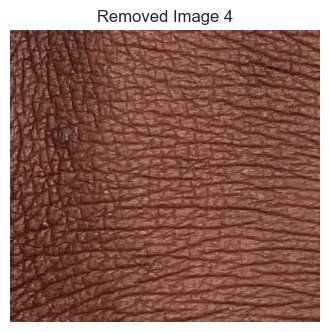

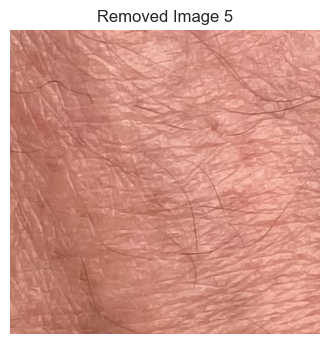

In [62]:
import matplotlib.pyplot as plt

# Assuming removed_ims contains a list of BGRA images
for i, im in enumerate(cropped_rect_ims):
    # Convert BGRA image to RBGA
    # grayscale_im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)

    plt.figure(figsize=(4, 4))
    plt.imshow(im, cmap='gray') 
    plt.title(f'Removed Image {i + 1}')
    plt.axis('off')
    plt.show()

Multiple Cropping

In [65]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os


def multi_crop_palm(image_path, cropped_images_dict):
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands

    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.01) as hands:

        # Get the filename from the image path
        image_filename = os.path.basename(image_path)

        # Read image file
        image = cv2.flip(cv2.imread(image_path), 1)

        # Convert BGR image to RGB
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.multi_hand_landmarks:
            print("No hands detected in the image.")
        else:
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()

            # Get first hand
            hand_landmarks = results.multi_hand_landmarks[0]

            landmark_9 = (
                int(hand_landmarks.landmark[9].x * image_width),
                int(hand_landmarks.landmark[9].y * image_height)
            )

            landmark_10 = (
                int(hand_landmarks.landmark[10].x * image_width),
                int(hand_landmarks.landmark[10].y * image_height)
            )

            # Define rectangle thickness
            rect_thickness = 2 

            # Draw rectangles around landmarks 9 and 10
            rect_color = (0, 0, 255) 
            rect_size = 40  

            cv2.rectangle(annotated_image, 
                          (landmark_9[0] - rect_size, landmark_9[1] - rect_size),
                          (landmark_9[0] + rect_size, landmark_9[1] + rect_size),
                          rect_color, rect_thickness)

            cv2.rectangle(annotated_image, 
                          (landmark_10[0] - rect_size, landmark_10[1] - rect_size),
                          (landmark_10[0] + rect_size, landmark_10[1] + rect_size),
                          rect_color, rect_thickness)

            # Crop images inside landmarks 9 and 10
            cropped_image_9 = annotated_image[landmark_9[1] - rect_size + rect_thickness : 
                                              landmark_9[1] + rect_size - rect_thickness,
                                              landmark_9[0] - rect_size + rect_thickness : 
                                              landmark_9[0] + rect_size - rect_thickness]

            cropped_image_10 = annotated_image[landmark_10[1] - rect_size + rect_thickness : 
                                                landmark_10[1] + rect_size - rect_thickness,
                                                landmark_10[0] - rect_size + rect_thickness : 
                                                landmark_10[0] + rect_size - rect_thickness]

            # Display cropped images
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Landmark 9")
            plt.imshow(cropped_image_9[:, :, ::-1])
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Landmark 10")
            plt.imshow(cropped_image_10[:, :, ::-1])
            plt.axis('off')

            plt.show()

            plt.title("Resultant Image"); plt.axis('off'); plt.imshow(annotated_image[:,:,::-1]); 
            plt.show()

            # Append the cropped images to the dictionary using the image filename as the key
            cropped_images_dict[image_filename] = [cropped_image_9, cropped_image_10]

# Initialize an empty dictionary
cropped_images_dict = {}


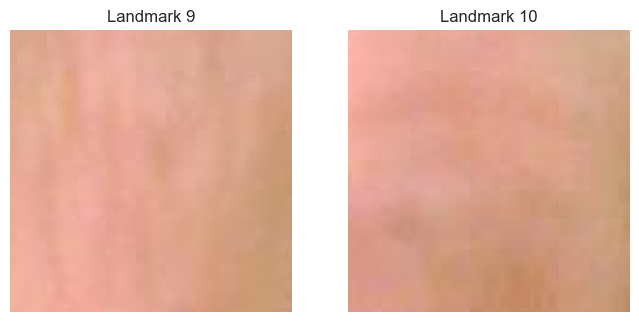

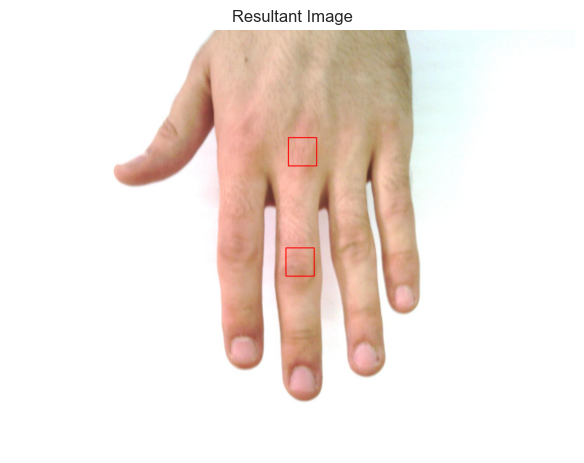

In [66]:
multi_crop_palm('/Applications/DermaML/Hand_0000002.jpg', cropped_images_dict)

In [38]:
print(cropped_images_dict)

{'Hand_0000002.jpg': [array([[[141, 165, 217],
        [141, 165, 217],
        [141, 165, 217],
        ...,
        [146, 169, 215],
        [141, 167, 213],
        [141, 167, 213]],

       [[141, 165, 217],
        [142, 166, 218],
        [141, 165, 217],
        ...,
        [146, 169, 215],
        [141, 167, 213],
        [141, 167, 213]],

       [[141, 165, 217],
        [142, 166, 218],
        [141, 165, 217],
        ...,
        [146, 169, 215],
        [141, 167, 213],
        [141, 167, 213]],

       ...,

       [[160, 179, 240],
        [159, 178, 239],
        [158, 176, 239],
        ...,
        [123, 156, 201],
        [122, 155, 200],
        [124, 155, 200]],

       [[160, 179, 240],
        [158, 176, 239],
        [158, 176, 239],
        ...,
        [123, 156, 201],
        [128, 159, 204],
        [129, 158, 203]],

       [[159, 176, 239],
        [157, 174, 237],
        [158, 175, 238],
        ...,
        [120, 153, 198],
        [124, 153, 197],
  